# Molecular Dynamics Simulation of Alanine Dipeptide

In this notebook, we will be using the latest AMBER force fields. The OpenMM documentation contains [a complete overview of included force fields](http://docs.openmm.org/latest/userguide/application.html#force-fields). The corresponding data files can be viewed on the [GitHub repository](https://github.com/openmm/openmm/tree/master/wrappers/python/openmm/app/data). These files are already included in every OpenMM installation, so you don't need to download them.

Just to avoid getting lost in the force field zoo, here are the key references to various AMBER force fields and some comments on the history of their development:

- 1997 `amber96.xml`: a slight improvement of AMBER ff94 with ab initio calculations, not very significant. [REF](https://doi.org/10.1007/978-94-017-1120-3_2)

- 2006 `amber99sb.xml`: a refinement of amber ff94 side-chain and mostly backbone (SB) torsional parameters, to obtain better balance between stabilities of different secondary structure elements, in the literature referred to as AMBER ff99SB. [REF](https://dx.doi.org/10.1002%2Fprot.21123)

- 2003 `amber03.xml`: improvement of AMBER ff99SB by refitting of torsional parameters to ab initio data, referred to as AMBER ff03. [REF](https://doi.org/10.1002/jcc.10349)

- 2010 `amber99sbildn.xml`: refitting of AMBER ff99sb to improve side-chain conformations to match NMR data, in the literature referred to as AMBER ff99SB-ILDN. [REF](https://dx.doi.org/10.1002%2Fprot.22711)

- 2010 `amber99sbnmr.xml`: another (not as popular) refitting of AMBER ff99SB parameters to NMR data. [REF](https://doi.org/10.1002/anie.201001898)

- ???? `amber10.xml`: origin not clear (yet), it is certainly an intermediate step in the development of AMBER ff14SB.

- 2015 `amber14-all.xml` or `amber14/protein.xml`: improved side-chain and backbone parameters starting from AMBER ff99SB, in the literature referred to as AMBER ff14SB. [REF](https://doi.org/10.1021/acs.jctc.5b00255)

One of the more recent and widely used AMBER force field is **AMBER ff14SB**. If for some reason, you need to use an older model, **AMBER ff99SB-ILDN** or **AMBER ff99SB** could be useful. The remaining ones are rarely used anymore. Also a few newer developments exist but will not be used in this course.

Another popular family of biomolecular force fields are the CHARMM force fields. The [CHARMM36](https://doi.org/10.1021/ct300400x) force field was published in 2012 and its development followed similar steps as that of AMBER. In 1992 the CHARMM22 force field was released. In 2004, so-called [CMAP corrections](https://doi.org/10.1021/ja036959e) were released based on *ab initio* reference data, to improve the accuracy of the backbone conformations. In CHARMM36 this was taken one (big) step further, with more accurate *ab initio* data and follow-up refinements against NMR data.
The files `charmm36.xml` and `charmm36/*.xml` were only included recently in OpenMM and these will not be used for this year's edition of the tutorial.


## 1. Gas phase (AMBER)

All imports and initialization are put in the first cell.

In [1]:
%matplotlib widget

In [2]:
from sys import stdout

import matplotlib.pyplot as plt
import mdtraj
import nglview
import numpy as np
import pandas
from simtk.openmm import *
from simtk.openmm.app import *
from simtk.unit import *

We will run test simulations on tiny "protein": alanine dipeptide. Data files for this notebook were taken from the [OpenMM test systems](https://github.com/openmm/openmm/tree/master/wrappers/python/tests/systems). The files `alanine-dipeptide-implicit.*` were renamed as follows:

* `alanine-dipeptide.pdb` (All-atom PDB file.)
* `alanine-dipeptide.inpcrd` (AMBER input coordinates)
* `alanine-dipeptide.prmtop` (AMBER parameters and topology)

The simulation code below closely follows the water example from the previous notebook with a few minor differences:

- The topology and the initial positions are now taken from a PDB file

- A Langevin integrator is used, with different settings and more MD steps.

- The AMBER 2014 force field is used.

- X-H bonds are constrained in length, where X can be any atom. This allows us to take time steps of 2 femtoseconds.

This is an unrealistic simulation because the dipeptide is simulated in gas phase (no solvation).

In [3]:
pdb = PDBFile('alanine-dipeptide.pdb')
print(pdb.topology)
forcefield = ForceField('amber14-all.xml')
system = forcefield.createSystem(
    pdb.topology, nonbondedCutoff=3*nanometer, constraints=HBonds)
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 2*femtoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()

<Topology; 1 chains, 3 residues, 22 atoms, 21 bonds>



**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Modify the PDB file to understand which pieces of information are essential to apply the force-field definition. Try making changes to:
>
> 1. the atom names, 
> 2. the name of a residue, 
> 3. the order of the atoms (within one residue or mixing residues) and 
> 4. the presence of atoms.
>
> Also note that the PDB file contains no bonds. These are somehow reconstructed when loading the PDB file. Try displacing one atom over a large distance. Does this affect the bond detection?

In the next cell, an MD simulation is carried out and the trajectory is written to a DCD file. This is a compact binary file format for trajectory data. This does not only save disk space. Also loading DCD files is much faster compared to PDB trajectory files.

In [4]:
simulation.reporters = []
simulation.reporters.append(DCDReporter('traj1.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars1.csv", 100, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True))
simulation.step(100000)

# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation

#"Step","Temperature (K)","Elapsed Time (s)"
1000,256.2638254642885,9.226799011230469e-05
2000,254.76270680932078,0.03330373764038086
3000,400.19604355958893,0.07732057571411133
4000,232.7033509869538,0.12941789627075195
5000,372.495051845076,0.1754779815673828
6000,358.3651808932477,0.20383048057556152
7000,369.91160184622635,0.2391195297241211
8000,223.60642432049482,0.26800084114074707
9000,242.81940225903574,0.29492831230163574
10000,269.71486497165716,0.3264930248260498
11000,268.3641294936911,0.3525125980377197
12000,275.3272253487035,0.3794746398925781
13000,265.8695930915353,0.40600061416625977
14000,278.4794320180588,0.4346649646759033
15000,215.17473967120583,0.46280717849731445
16000,353.9957261719195,0.4912891387939453
17000,303.0063688372851,0.5175354480743408
18000,320.90688093540297,0.5447146892547607
19000,262.611201033613,0.5711572170257568
20000,330.2348672238532,0.5977427959442139
21000,295.04976060001513,0.6256120204925537
22000,388.21626592261833,0.6524572372436523

In the next code cell, the potential energy as function of time is plotted. It reveals a very short equilibration phase. Because the energy was first minimized, the potential energy starts low and increases quickly due to the motion of the atoms.

Normally, the equilibration phase should be discarded prior to further analysis. For now, the equilibration phase is included in the analysis to explain and show this aspect.

<AxesSubplot:xlabel='#"Time (ps)"'>

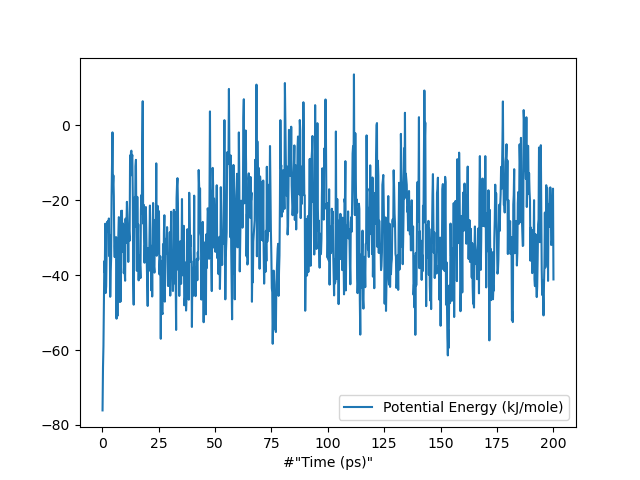

In [5]:
df1 = pandas.read_csv("scalars1.csv")
df1.plot(kind='line', x='#"Time (ps)"', y='Potential Energy (kJ/mole)')

The visualization below shows a few changes in conformation of the dipeptide.

In [6]:
traj1 = mdtraj.load('traj1.dcd', top='alanine-dipeptide.pdb')
traj1.superpose(traj1, 0)
nglview.show_mdtraj(traj1)

NGLWidget(max_frame=999)

The following cell defines a function to draw a [Ramachandran plot](https://en.wikipedia.org/wiki/Ramachandran_plot) with MatPlotLib. As opposed to a conventional Ramachandran plot, data points represents different conformations (time steps) of the $\phi$ and $\psi$ angles.

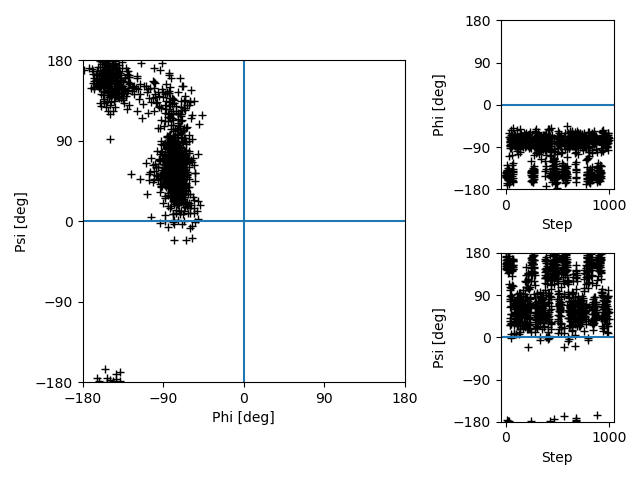

In [7]:
def plot_ramachandran(traj, phi_atoms=None, psi_atoms=None):
    """Generate a basic Ramachandrom plot for a given trajectory.

    Parameters
    ----------
    traj
        An MDTraj trajectory object.
    phi_atoms
        A list of atom names (in order) to identify the phi angle.
        The defaults in MDTraj do not work for termini in CHARMM
        topologies, which can be fixed with this argument.
    psi_atoms
        A list of atom names (in order) to identify the psi angle.
        The defaults in MDTraj do not work for termini in CHARMM
        topologies, which can be fixed with this argument.

    """
    from matplotlib.gridspec import GridSpec
    if phi_atoms is None:
        phis = mdtraj.compute_phi(traj)[1].ravel()
    else:
        phis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, phi_atoms)[1])
    if psi_atoms is None:
        psis = mdtraj.compute_psi(traj)[1].ravel()
    else:
        psis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, psi_atoms)[1])
    fig = plt.figure()
    gs = GridSpec(nrows=2, ncols=3)
    # Ramachandran plot
    ax1 = fig.add_subplot(gs[:2, :2])
    ax1.plot(phis*180/np.pi, psis*180/np.pi, 'k+')
    ax1.set_aspect('equal', adjustable='box')
    ax1.axvline(0)
    ax1.axhline(0)
    ax1.set_xlim(-180, 180)
    ax1.set_ylim(-180, 180)
    ax1.set_xticks(np.linspace(-180, 180, 5))
    ax1.set_yticks(np.linspace(-180, 180, 5))
    ax1.set_xlabel("Phi [deg]")
    ax1.set_ylabel("Psi [deg]")
    # Phi(t) plot
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(np.arange(len(phis)), phis*180/np.pi, 'k+')
    ax2.axhline(0)
    ax2.set_ylim(-180, 180)
    ax2.set_yticks(np.linspace(-180, 180, 5))
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Phi [deg]")
    # Psi(t) plot
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.plot(np.arange(len(phis)), psis*180/np.pi, 'k+')
    ax3.axhline(0)
    ax3.set_ylim(-180, 180)
    ax3.set_yticks(np.linspace(-180, 180, 5))
    ax3.set_xlabel("Step")
    ax3.set_ylabel("Psi [deg]")
    fig.tight_layout()


# Function call to make the plot
plot_ramachandran(traj1)

## 2. Implicit solvent model (AMBER with GBSA-OBC)

OpenMM supports various parameterizations of the generalized-Born Surface Area (GBSA) model, e.g. that by 
Onufriev, Bashford and Case (OBC), see https://doi.org/10.1002/prot.20033. For a limited number of force fields, atomic GBSA-OBC parameters were generated according to a recipe in the [TINKER](https://dasher.wustl.edu/tinker/) program:

- `amber96_obc.xml` for `amber96.xml`
- `amber03_obc.xml` for `amber03.xml`
- `amber10_obc.xml` for `amber10.xml`
- `amber99_obc.xml` for `amber99sb.xml`, `amber99sbildn.xml` or `amber99sbnmr.xml`

These can be used by changing the force field definition, e.g. to `ForceField('amber99sbildn.xml', 'amber99_obc.xml')`. Keep in mind that these extra atomic parameters for GBSA-OBC deviate from those in the [AMBER](http://ambermd.org/) program. OpenMM does not natively support implicit solvent models for AMBER ff14SB, and workarounds for this problem are not covered in this course. Instead, a slightly older AMBER parametrization will be used instead.

In [8]:
forcefield = ForceField('amber99sbnmr.xml', 'amber99_obc.xml')
system = forcefield.createSystem(
    pdb.topology, nonbondedCutoff=3*nanometer, constraints=HBonds)
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 2*femtoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()

simulation.reporters = []
simulation.reporters.append(DCDReporter('traj2.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars2.csv", 100, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True))
simulation.step(100000)

#"Step","Temperature (K)","Elapsed Time (s)"
1000,312.062997129097,0.00010466575622558594
2000,284.5915744200236,0.07908082008361816
3000,254.71644375457498,0.13062119483947754
4000,420.04616034351653,0.1773700714111328
5000,247.21743009451012,0.22504615783691406
6000,314.8860508594332,0.28019165992736816
7000,293.7867501402236,0.33147168159484863
8000,320.0957377159256,0.39884161949157715
9000,251.15052922275305,0.4451584815979004
10000,264.8241518541564,0.49385786056518555
11000,298.9956774562814,0.5415809154510498
12000,459.6119362782485,0.5900287628173828
13000,295.88822450368184,0.6405565738677979
14000,315.0260024571876,0.6896188259124756
15000,254.84225417412077,0.7401230335235596
16000,260.87605526373295,0.7931969165802002
17000,307.4253369221133,0.8426978588104248
18000,440.26674812256226,0.8893692493438721
19000,207.32631362071038,0.9357414245605469
20000,252.24454928035829,0.9817874431610107
21000,273.85292953350324,1.0298283100128174
22000,211.52469758481737,1.0771362781524

With the implicit solvent model, the computational cost increases by approximately 60%.
This increase may vary with system size.

The potential energy as a function of time shows a short equilibration phase, comparable to the previous example:

<AxesSubplot:xlabel='#"Time (ps)"'>

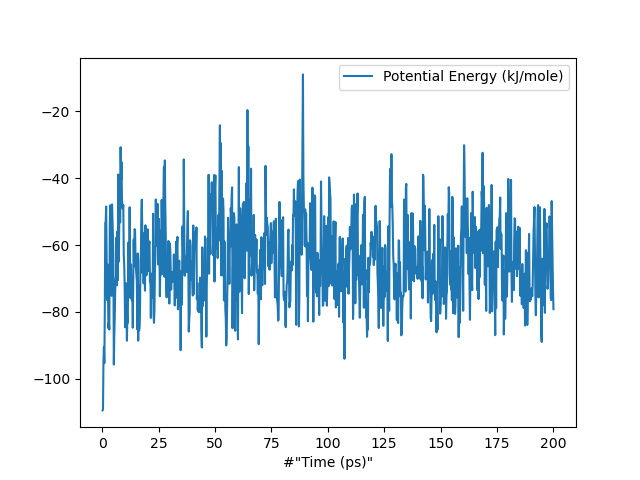

In [9]:
df2 = pandas.read_csv("scalars2.csv")
df2.plot(kind='line', x='#"Time (ps)"', y='Potential Energy (kJ/mole)')

We can now compare the structure of the backbone with and without implicit solvent. Also compare with figures obtained by other students.

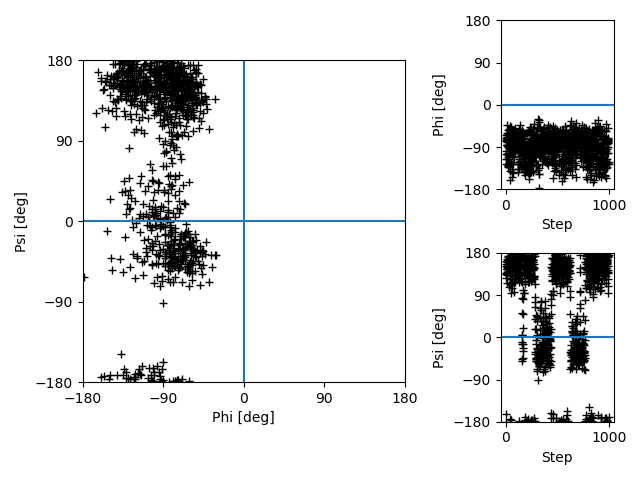

In [10]:
traj2 = mdtraj.load('traj2.dcd', top='alanine-dipeptide.prmtop')
plot_ramachandran(traj2)

## 3. Explicit solvent model (AMBER)

Any implicit solvent model will always be a serious approximation of explicit water molecules surrounding a solute. Before we can run such a simulation, we need to construct a topology and initial geometry of alanine dipeptide with a large number of water molecules. This can be done in several ways and for simplicity, we will use the built-in tools from OpenMM. For this example, we can again start from a PDB file.

This example is based on the following parts of the OpenMM documentation:

* http://docs.openmm.org/latest/userguide/application.html#model-building-and-editing
* http://docs.openmm.org/latest/api-python/generated/openmm.app.modeller.Modeller.html#openmm.app.modeller.Modeller


One is in principle free to combine any biomolecule with any water force field, but not all combinations may have been carefully tested. Always check the original papers in which the force field was published to select matching pairs. To avoid confusion, the latest AMBER and CHARMM force fields in OpenMM are bundeled with matching water force fields. Here are a few sensible combinations:

* `amber14-all.xml` can be paired with any TIP or SPC model in the `amber14` directory, see https://github.com/openmm/openmm/tree/master/wrappers/python/openmm/app/data/amber14

* `charm36.xml` should be combined with water force fields in the `charmm36` directory, see https://github.com/openmm/openmm/tree/master/wrappers/python/openmm/app/data/charmm36. Note that `charmm36/water.xml` is a slightly modified form of TIP3P.

* The parameters in `amber99sbildn.xml` [were tested](https://dx.doi.org/10.1002%2Fprot.22711) with TIP3P (`tip3p.xml`) and TIP4P-Ew (`tip4pew.xml`), see https://github.com/openmm/openmm/tree/master/wrappers/python/openmm/app/data.

The files from the Github repository should normally never be downloaded and links are only provided for reference. These files are included with any OpenMM installation and are already present on your machine.

In [11]:
pdb = PDBFile('alanine-dipeptide.pdb')
modeller = Modeller(pdb.topology, pdb.positions)
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
modeller.addSolvent(forcefield, model='tip3p', padding=1*nanometer)
print(modeller.topology)
# Write a PDB file to provide a topology of the solvated
# system to MDTraj below.
with open('init3.pdb', 'w') as outfile:
    PDBFile.writeFile(modeller.topology, modeller.positions, outfile)

# The modeller builds a periodic box with the solute and solvent molecules.
# PME is the method to compute long-range electristatic interactions in
# periodic systems.
system = forcefield.createSystem(
    modeller.topology, nonbondedMethod=PME, constraints=HBonds)
temperature = 300 * kelvin
pressure = 1 * bar
integrator = LangevinIntegrator(temperature, 1/picosecond, 2*femtoseconds)
system.addForce(MonteCarloBarostat(pressure, temperature))
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()
simulation.reporters.append(DCDReporter('traj3.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars3.csv", 100, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True))
simulation.step(100000)

# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation

<Topology; 2 chains, 661 residues, 1996 atoms, 1337 bonds>
#"Step","Temperature (K)","Elapsed Time (s)"
1000,241.40823831717094,9.441375732421875e-05
2000,281.34576985581054,0.2576780319213867
3000,302.52656386502196,0.5052187442779541
4000,291.01092083351335,0.7495319843292236
5000,286.0699887412378,1.0605158805847168
6000,286.78795244264444,1.408918857574463
7000,311.87084074935177,1.6767902374267578
8000,289.24581002614974,2.0637383460998535
9000,309.29462397689264,2.300353765487671
10000,298.754101712901,2.6490495204925537
11000,307.11839920707564,2.8872671127319336
12000,293.83930772371343,3.1276347637176514
13000,297.5848849645407,3.437039375305176
14000,292.90265967838485,3.673701047897339
15000,304.5528778691217,3.913297414779663
16000,299.7720696555046,4.149139404296875
17000,306.6823134759401,4.3890697956085205
18000,310.24330190293085,4.814579010009766
19000,295.04079507549864,5.053470611572266
20000,295.8058646606481,5.302479982376099
21000,296.00960851770117,5.600904226303

This computation was considerably slower, approximately a factor of 10 more expensive.

Before going further, we plot the potential energy as function of time, to estimate the length of the equilibration phase. There was barely any equilibration in the previous two runs, mainly because the few degrees of freedom were all relatively fast motions. More complex structures tend to exhibit also slower motions. For example, in our current run with explicit water molecules, the solvent needs more time to equilibrate.

<AxesSubplot:xlabel='#"Time (ps)"'>

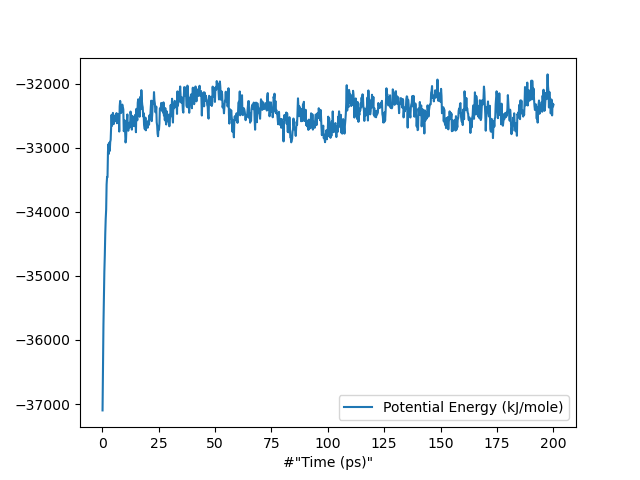

In [12]:
df3 = pandas.read_csv("scalars3.csv")
df3.plot(kind='line', x='#"Time (ps)"', y='Potential Energy (kJ/mole)')

The figure above shows that approximately (the first) 15 picoseconds are required for the equilibration. Results for these steps need to be removed before performing any analysis. A single MD step takes 2 femtoseconds and only every 100 steps, a frame is written to the PDB file, which means that the first 75 frames from the trajectory should be removed. For the visualization, we still look at all steps.

In [13]:
traj3 = mdtraj.load('traj3.dcd', top='init3.pdb')
view = nglview.show_mdtraj(traj3)
view.clear_representations()
view.add_licorice()
view.add_unitcell()
view

NGLWidget(max_frame=999)

A few remarks on the visualization:

- The absolute position of the dipeptide relative to the box is not crucial. Due to the periodic boundary conditions, all molecules interact with an infinitely large environment, of which the visualization only shows a small fragment.

- The dipeptide slowly diffuses through the liquid, which is the expected behavior. Water molecules make larger jumps because they are smaller and lighter.

In the next cell, the equilibration phase is discarded and the water molecules are removed, before making the Ramachandran plot.

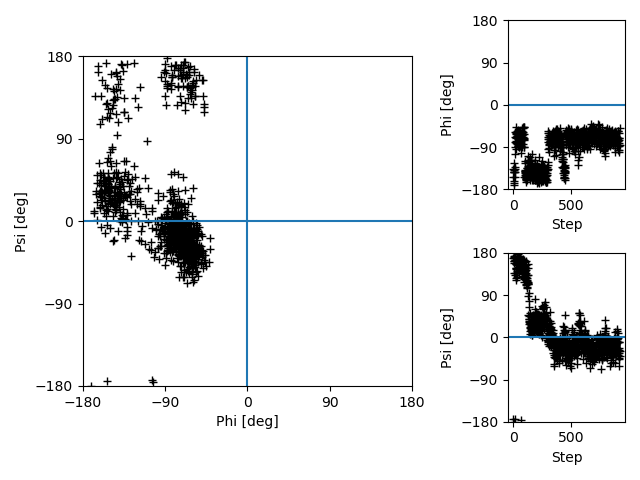

In [14]:
traj3.restrict_atoms(traj3.topology.select("protein"))
plot_ramachandran(traj3[75:])

The Ramachandran plot is strongly influenced by the choice of solvent model. Already for a simple dipeptide, the limitations of an implicit solvent model are clear. The reason is that the amide groups participate in the hydrogen-bonding network of the solvent. These are rather specific and directional interactions, which are absent in implicit solvent models.

Another difference with the first two runs is the slower change of the back-bone angles. There are fewer changes between conformations and switching also takes longer. This is due to the friction with and the inertia of the surrounding water molecules. Hence, a single time step with explicit solvent is more costly and one has to perform longer simulations because water slows down conformational changes. For this reason, implicit solvent models are still popular, despite the fact that they are very approximate. Note that the explicit-solvent simulations in this notebook are not long enough to obtain converged statistics.